In [1]:
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import io
from tqdm import tqdm
import re

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from misc.utils import get_dict_item, read_lines
from misc.tb_analysis import get_data, get_metrics, get_results

2023-12-05 14:11:23.439838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 14:11:23.439925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 14:11:23.442600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 14:11:23.544825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 14:11:29.738566: W tensorflow/compiler/tf2

In [2]:
data = get_data(filter = 'lpsda_mimic.*version_4')
keys = list(data.keys())
print(len(keys))
print(keys)

39
['datalpsda_mimic_netFNO1d_KdV_aug0.0-0.25-0.0-0.0_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.0-1.0_seed1_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.5-0.0-0.0_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.5-0.0_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.0-0.25_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.25-0.0-0.0_seed1_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.0-0.75_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-1.0-0.0_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.0-0.75_seed2_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-1.0-0.0-0.0_seed1_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-1.0-0.0-0.0_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.5-0.0-0.0_seed2_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.75-0.0-0.0_seed2_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.0-0.5_seed3_version_4', 'datalpsda_mimic_netFNO1d_KdV_aug0.0-0.0-0.0-0.75_se

In [3]:
data = get_results(data, metrics = ['test_loss'])

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [06:14<00:00,  9.60s/it]


In [17]:
def get_hparams(version):
    epss = version.split('_')[4].replace('aug', '').split('-')
    epss = np.array([float(e) for e in epss])
    nonzeros_eps_idxs = np.where(epss != 0)[0]
    if len(nonzeros_eps_idxs) == 0:
        eps = 0
        nonzeros_eps_idx = -1
    elif len(nonzeros_eps_idxs) == 1:
        nonzeros_eps_idx = nonzeros_eps_idxs[0]
        eps = epss[nonzeros_eps_idx]
    else:
        raise ValueError('More than one non-zero eps')

    return {'eps': eps, 'gen_idx': nonzeros_eps_idx+1}

In [18]:
for version, version_dict in data.items():
    hparams = get_hparams(version)
    version_dict.update(hparams)

In [19]:
gens = np.unique(np.array([v['gen_idx'] for v in data.values()]))
gen_dict = { gen : rf'$g_{gen}$' if gen != 0 else r'$\emptyset$' for gen in gens  }


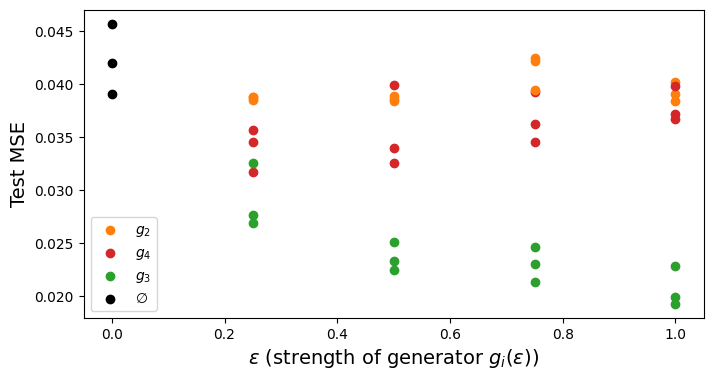

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
ax = axs

color_dict = {gen : plt.cm.tab10(i) for i, gen in enumerate(gens)}
color_dict[0] = 'black'


labels = set()
for k, v in data.items():
    loss = v['test_loss']

    if len(loss) == 0:
        continue
    
    label = gen_dict[v['gen_idx']]
    if label not in labels:
        labels.add(label)
    else:
        label = None

    if v['gen_idx'] == -1:
        ax.hlines(loss, 0, 1, color = color_dict[v['gen_idx']], linestyle = '--', label = label)
    else:
        ax.scatter(v['eps'], loss, color = color_dict[v['gen_idx']], label = label)

    ax.set_xlabel(r'$\epsilon$ (strength of generator $g_i(\varepsilon)$)', size = 14)
    ax.set_ylabel('Test MSE', size = 14)

ax.legend()
plt.show()


### Old stuff

In [8]:
assert False

AssertionError: 

In [ ]:
n_iterations = get_dict_item(data)[1]['val_loss'].shape[0]
val_losses = np.full((2, len(data)//2, n_iterations), np.nan)
test_losses = np.full((2, len(data)//2, 1), np.nan)
print(val_losses.shape)

(2, 5, 1000)


In [ ]:
for version, version_dict in data.items():
    i_aug = 0 if 'aug0_' in version else 1
    seed = int(version[int(version.find('seed') + 4)])
    val_losses[i_aug, seed-1] = version_dict['val_loss']
    test_losses[i_aug, seed-1] = version_dict['test_loss']

assert np.isnan(val_losses).sum() == 0


In [ ]:
means, stds = np.mean(test_losses, axis = 1).reshape(-1), np.std(test_losses, axis = 1).reshape(-1)
for mean, std in zip(means, stds):
    print(f"{mean:.4f} ± {std:.4f}")

0.0342 ± 0.0011
0.0324 ± 0.0026


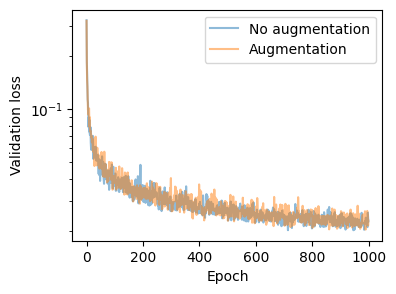

In [ ]:
colors = ['tab:blue', 'tab:orange']
labels = ['No augmentation', 'Augmentation']


fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for i, val_loss_aug in enumerate(val_losses):
    mean = val_loss_aug.mean(axis = 0)
    std = val_loss_aug.std(axis = 0)

    ax.plot(mean, color = colors[i], label = labels[i], alpha = 0.5)
    # ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha = 0.5, color = colors[i])

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_yscale('log')
ax.legend()
plt.show()

### More plots

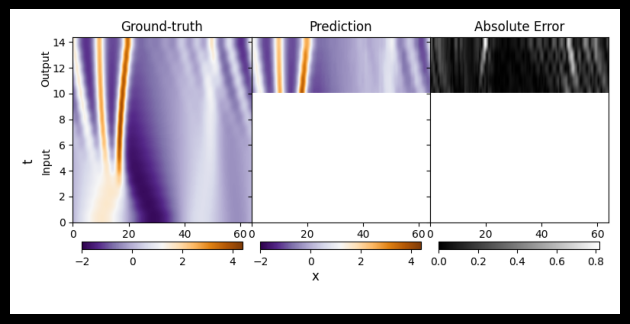

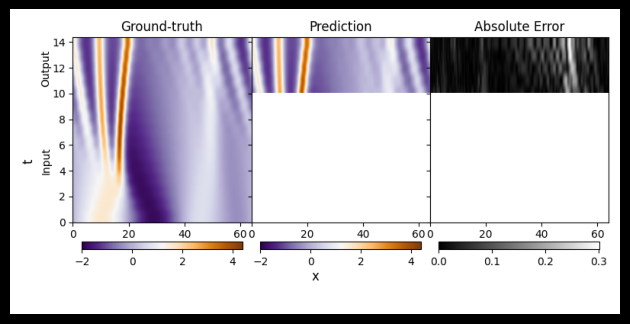

In [ ]:
keys = ['FNO1d_precision_datasympde_aug0_KdV_seed4', 'FNO1d_precision_datasympde_aug1_KdV_seed4']
for key in keys:
    images = data[key]['val_plot']
    im = images[-1]
    plt.figure(tight_layout=True)
    plt.imshow(im)
    plt.axis('off')
    plt.show()